In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")


# Objetivos

1. Existe diferença de incidência de covid entre homens e mulheres?
   
2. Faça um gráfico da mortalidade por faixas de idade.
   
3. Qual a doença pré-existente mais provável de se encontrar numa pessoa com covid?
   
4. Baseado nesses dados, faça um modelo que estime a probabilidade da pessoa morrer, uma vez que está       contaminada com covid, e considerando os inputs de idade, gênero e doenças pré-existentes.

Fonte: https://www.saopaulo.sp.gov.br/planosp/simi/dados-abertos/
arquivo CSV de microdados dos casos.

# Importando os Dados
- ter o arquivo 20240120_Casos_e_obitos_ESP.csv na mesma pasta de trabalho do jupyter notebook

In [2]:
df_micro_dados= pd.read_csv('20240120_Casos_e_obitos_ESP.csv',delimiter=';')
descricao ="Base de dados com registros individualizados e anonimizados, detalhados com os seguintes campos:\nNotificações, Evolução, Confirmação do caso para COVID-19, Idade, Gênero, Doenças Preexistentes,\nSintomas, Raça/Cor, Etnia, Município, Profissionais de Saúde"

In [3]:
# Etapa opcional, transformar o dataframe em lower case (~30s de execução)
df_micro_dados = df_micro_dados.applymap(lambda s: s.lower() if type(s) == str else s)

In [4]:
print(f'Descrição :\n{descricao}')
df_micro_dados.head(2)

Descrição :
Base de dados com registros individualizados e anonimizados, detalhados com os seguintes campos:
Notificações, Evolução, Confirmação do caso para COVID-19, Idade, Gênero, Doenças Preexistentes,
Sintomas, Raça/Cor, Etnia, Município, Profissionais de Saúde


,Asma,Cardiopatia,Data_Inicio_Sintomas,Diabetes,Diagnostico_Covid19,Doenca_Hematologica,Doenca_Hepatica,Doenca_Neurologica,Doenca Renal,Genero,Idade,Imunodepressao,Municipio,Obesidade,Obito,Outros_Fatores_De_Risco,Pneumopatia,Puérpera,Síndrome_De_Down
0,ignorado,ignorado,15/07/2022,ignorado,confirmado,ignorado,ignorado,ignorado,ignorado,masculino,69.0,ignorado,assis,ignorado,0,ignorado,ignorado,ignorado,ignorado
1,ignorado,ignorado,21/02/2021,ignorado,confirmado,ignorado,ignorado,ignorado,ignorado,feminino,60.0,ignorado,são paulo,ignorado,0,ignorado,ignorado,ignorado,ignorado


Importando dicionário de dados

(tabela pdf foi transformada em csv)

In [5]:
dic_dados = pd.read_csv('Dic-dados_microdados.csv', encoding='utf-8')
print('Dicionário de Dados')
dic_dados

Dicionário de Dados


,NOME DO CAMPO,CONTEÚDO,DESCRIÇÃO,OBSERVAÇÕES RELEVANTES
0,Gênero,Feminino / Masculino,Gênero do paciente,NaN
1,Município,Nome do município,Nome do município do Estado de São Paulo que o...,NaN
2,Asma,Sim / Não / Ignorado,Indica se tem este fator de risco,Doença respiratória crônica
3,Diabetes,Sim / Não / Ignorado,Indica se tem este fator de risco,Doença causada pela produção insuficiente ou ...
4,Cardiopatia,Sim / Não / Ignorado,Indica se tem este fator de risco,Doença cardíaca que afeta o coração e os vaso...
5,Doença Hematológica,Sim / Não / Ignorado,Indica se tem este fator de risco,Doença que compromete a produção dos componen...
6,Doença Hepática,Sim / Não / Ignorado,Indica se tem este fator de risco,Qualquer condição que danifica o fígado e imp...
7,Doença Neurológica,Sim / Não / Ignorado,Indica se tem este fator de risco,"Doença que afetam o cérebro, a medula espinha..."
8,Doença Renal,Sim / Não / Ignorado,Indica se tem este fator de risco,Doença que faz com que rins percam a capacida...
9,Imunodepressão,Sim / Não / Ignorado,Indica se tem este fator de risco,Enfraquecimento ou supressão do sistema imuno...


## Classificando as colunas
- Doenças
- Outras informações

In [6]:
df_micro_dados.columns

Index(['Asma', 'Cardiopatia', 'Data_Inicio_Sintomas', 'Diabetes',
       'Diagnostico_Covid19', 'Doenca_Hematologica', 'Doenca_Hepatica',
       'Doenca_Neurologica', 'Doenca Renal', 'Genero', 'Idade',
       'Imunodepressao', 'Municipio', 'Obesidade', 'Obito',
       'Outros_Fatores_De_Risco', 'Pneumopatia', 'Puérpera',
       'Síndrome_De_Down'],
      dtype='object')

Criando Dataframe apenas com colunas de doenças

In [7]:
# busca variáveis de doença no dicionário de dados
doencas_dic = dic_dados[dic_dados['CONTEÚDO'] =="Sim / Não / Ignorado"]['NOME DO CAMPO']
print(doencas_dic.tolist()) 
# remover acentos e espaços e ç (formatar igual nome das colunas)
doencas = ['Asma', 'Diabetes', 'Cardiopatia', 'Doenca_Hematologica', 'Doenca_Hepatica', 'Doenca_Neurologica', 'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia', 'Puérpera', 'Síndrome_De_Down', 'Outros_Fatores_De_Risco']
df_doencas = df_micro_dados[doencas]
df_doencas.head()

['Asma', 'Diabetes', 'Cardiopatia', 'Doença Hematológica', 'Doença Hepática', 'Doença Neurológica', 'Doença Renal', 'Imunodepressão', 'Obesidade', 'Pneumopatia', 'Puérpera', 'Síndrome de Down', 'Outros']


,Asma,Diabetes,Cardiopatia,Doenca_Hematologica,Doenca_Hepatica,Doenca_Neurologica,Doenca Renal,Imunodepressao,Obesidade,Pneumopatia,Puérpera,Síndrome_De_Down,Outros_Fatores_De_Risco
0,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado
1,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado
2,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado
3,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado
4,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado,ignorado


Criando Dataframe apenas com colunas de informações (não doenças)

In [8]:
# busca variáveis de infos no dicionário de dados )
infos_dic = dic_dados[dic_dados['CONTEÚDO'] !="Sim / Não / Ignorado"]['NOME DO CAMPO']
print(infos_dic.tolist()) 
# remover acentos e espaços e ç (formatar igual nome das colunas)
infos = ['Genero', 'Municipio', 'Diagnostico_Covid19', 'Data_Inicio_Sintomas', 'Idade', 'Obito']
df_infos = df_micro_dados[infos]
df_infos.head()

['Gênero', 'Município', 'Diagnostico Covid19', 'Data Início / Sintomas', 'Idade', 'Óbito']


,Genero,Municipio,Diagnostico_Covid19,Data_Inicio_Sintomas,Idade,Obito
0,masculino,assis,confirmado,15/07/2022,69.0,0
1,feminino,são paulo,confirmado,21/02/2021,60.0,0
2,masculino,araraquara,confirmado,23/06/2021,58.0,0
3,feminino,são paulo,confirmado,03/02/2021,45.0,0
4,feminino,são paulo,confirmado,23/02/2021,42.0,0


## Estratégia Resolução Case:
* **Pergunta 1 e 2)** 
  * Usar apenas o df_infos.
  
  
- **Pergunta 3)**
  -  Usar o df_doencas + variável 'Diagnostico_Covid19'
  

- **Pergunta 4)** 
  - usar o dataset completo. 
  
  - Filtro: 'Diagnóstico Covid19' == 'Confirmado'

  - Variáveis de entrada X = [[doenças], idade, gênero]; 
  
  - Variável alvo y = 'Óbito' (Binária)
  
 

# Exploração e ETL dos dados
conjunto completo 

## Avaliando Nulos/NaN


In [9]:
df_micro_dados.info()
# não está mostrando número de valores não nulos (possivelmente devido ao tamanho do dataset)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6770928 entries, 0 to 6770927
Data columns (total 19 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Asma                     object 
 1   Cardiopatia              object 
 2   Data_Inicio_Sintomas     object 
 3   Diabetes                 object 
 4   Diagnostico_Covid19      object 
 5   Doenca_Hematologica      object 
 6   Doenca_Hepatica          object 
 7   Doenca_Neurologica       object 
 8   Doenca Renal             object 
 9   Genero                   object 
 10  Idade                    float64
 11  Imunodepressao           object 
 12  Municipio                object 
 13  Obesidade                object 
 14  Obito                    int64  
 15  Outros_Fatores_De_Risco  object 
 16  Pneumopatia              object 
 17  Puérpera                 object 
 18  Síndrome_De_Down         object 
dtypes: float64(1), int64(1), object(17)
memory usage: 981.5+ MB


In [10]:
# Avaliando valores nulos
df_micro_dados.isnull().sum()

Asma                            0
Cardiopatia                     0
Data_Inicio_Sintomas       244724
Diabetes                        0
Diagnostico_Covid19             0
Doenca_Hematologica             0
Doenca_Hepatica                 0
Doenca_Neurologica              0
Doenca Renal                    0
Genero                          1
Idade                      221457
Imunodepressao                  0
Municipio                       0
Obesidade                       0
Obito                           0
Outros_Fatores_De_Risco         0
Pneumopatia                     0
Puérpera                        0
Síndrome_De_Down                0
dtype: int64

In [11]:
print(f"{round(df_micro_dados['Idade'].isnull().sum()/len(df_micro_dados['Idade'])*100,2)}% dos valores de idade são nulos")

3.27% dos valores de idade são nulos


Avaliando valores nulo de idade
- retornando quais valores únicos possuem as colunas com idade nula. 
  - Objetivo é ver se os dados estão preenchidos de forma correta nas demais colunas e podem ser usados, ou estão preenchidos incorretamente e devem ser descartados.

In [12]:
df_idade_nulo = df_micro_dados[df_micro_dados['Idade'].isna()]
df_idade_nulo = df_idade_nulo.drop(columns=['Data_Inicio_Sintomas','Municipio'])

unique_dict_idadenull = {}
for column in df_idade_nulo.columns:
    unique_dict_idadenull[column]= df_idade_nulo[column].unique()
    print(column, unique_dict_idadenull[column])
    
df_idade_nulo.head(2)

Asma ['ignorado']
Cardiopatia ['ignorado' 'sim']
Diabetes ['ignorado' 'sim']
Diagnostico_Covid19 ['confirmado']
Doenca_Hematologica ['ignorado']
Doenca_Hepatica ['ignorado']
Doenca_Neurologica ['ignorado']
Doenca Renal ['ignorado' 'sim']
Genero ['feminino' 'masculino' 'indefinido' 'ignorado']
Idade [nan]
Imunodepressao ['ignorado' 'sim']
Obesidade ['ignorado']
Obito [0]
Outros_Fatores_De_Risco ['ignorado']
Pneumopatia ['ignorado']
Puérpera ['ignorado']
Síndrome_De_Down ['ignorado']


,Asma,Cardiopatia,Diabetes,Diagnostico_Covid19,Doenca_Hematologica,Doenca_Hepatica,Doenca_Neurologica,Doenca Renal,Genero,Idade,Imunodepressao,Obesidade,Obito,Outros_Fatores_De_Risco,Pneumopatia,Puérpera,Síndrome_De_Down
34,ignorado,ignorado,ignorado,confirmado,ignorado,ignorado,ignorado,ignorado,feminino,NaN,ignorado,ignorado,0,ignorado,ignorado,ignorado,ignorado
115,ignorado,ignorado,ignorado,confirmado,ignorado,ignorado,ignorado,ignorado,feminino,NaN,ignorado,ignorado,0,ignorado,ignorado,ignorado,ignorado


### Conclusões
- A coluna 'Data_Inicio_Sintomas' não é relevante para a análise, e será excluída.
  
- A coluna idade terá seus valores nulos removidos.
  - A remoção dos valores nulos só será aplicada para responder as perguntas 2 e 4
  - Para as perguntas 1 e 3, que não utilizam essa variável,  os valores de idade nulo serão mantidos.

## Avaliando Variáveis Numéricas
- Óbito (variável binária)

- Idade (variável numérica)

Óbito

In [13]:
print(df_micro_dados['Obito'].value_counts())

obitos_perc = round(df_micro_dados[df_micro_dados['Obito'] == 1].shape[0] / df_micro_dados['Obito'].count(),3)
print(f"Os óbitos representam {obitos_perc}% do total de registros")
print("os dados são desbalanceados")

Obito
0    6588577
1     182351
Name: count, dtype: int64
Os óbitos representam 0.027% do total de registros
os dados são desbalanceados


Idade

In [14]:
pd.options.display.float_format = '{:.2f}'.format # remover notação cientifica do output

print(df_micro_dados['Idade'].describe())
pd.reset_option('display.float_format') # retornar a formatação padrão

count   6549471.00
mean         41.09
std          18.49
min           0.00
25%          28.00
50%          40.00
75%          54.00
max        2188.00
Name: Idade, dtype: float64


In [15]:
# entendendo outliers idade (máx=2188)
print(f"mediana: {df_micro_dados['Idade'].median()}")
print(f"média: {df_micro_dados['Idade'].mean()}")


mediana: 40.0
média: 41.089127808948234


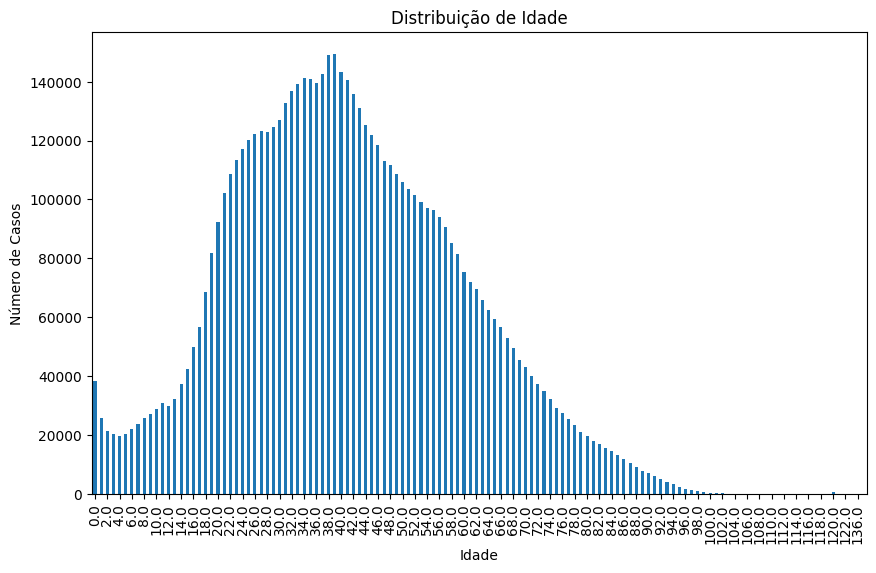

In [16]:
idade_counts = df_micro_dados['Idade'].value_counts().sort_index()

# Plotar o gráfico de barras
ax = idade_counts.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Idade')
plt.ylabel('Número de Casos')
plt.title('Distribuição de Idade')


# Definir os ticks que deseja exibi
ticks_to_show = range(0, len(idade_counts), 2)  # Exibe a cada segundo tick

# Definir os rótulos dos ticks correspondentes
ax.set_xticks(ticks_to_show)
ax.set_xticklabels(idade_counts.index[ticks_to_show])

# Mostrar o gráfico
plt.show()

Filtrando idades maiores de 100 para entender se podem ser removidas

In [17]:
idade_max = 100
idade_maior= df_micro_dados[df_micro_dados['Idade']>idade_max]['Idade'].count()/len(df_micro_dados['Idade'])
print(f'Pessoas maiores de {idade_max} anos representam {round(idade_maior*100,2)}% dos dados')

df_micro_dados[df_micro_dados['Idade']>idade_max].head(3)

Pessoas maiores de 100 anos representam 0.03% dos dados


,Asma,Cardiopatia,Data_Inicio_Sintomas,Diabetes,Diagnostico_Covid19,Doenca_Hematologica,Doenca_Hepatica,Doenca_Neurologica,Doenca Renal,Genero,Idade,Imunodepressao,Municipio,Obesidade,Obito,Outros_Fatores_De_Risco,Pneumopatia,Puérpera,Síndrome_De_Down
1432,ignorado,ignorado,09/05/2022,ignorado,confirmado,ignorado,ignorado,ignorado,ignorado,feminino,101.0,ignorado,são paulo,ignorado,0,ignorado,ignorado,ignorado,ignorado
4846,ignorado,ignorado,NaN,ignorado,confirmado,ignorado,ignorado,ignorado,ignorado,masculino,120.0,ignorado,são paulo,ignorado,0,ignorado,ignorado,ignorado,ignorado
4847,ignorado,ignorado,NaN,ignorado,confirmado,ignorado,ignorado,ignorado,ignorado,masculino,120.0,ignorado,são paulo,ignorado,0,ignorado,ignorado,ignorado,ignorado


### Conclusões
* Serão removidos todas idades maior que 100 anos, considerados outliers.
  * Serão removidas de todas análises

## Avaliando Variáveis categóricas
- Avaliando se todas colunas possuem os valores corretos

In [18]:
df_micro_dados.columns

Index(['Asma', 'Cardiopatia', 'Data_Inicio_Sintomas', 'Diabetes',
       'Diagnostico_Covid19', 'Doenca_Hematologica', 'Doenca_Hepatica',
       'Doenca_Neurologica', 'Doenca Renal', 'Genero', 'Idade',
       'Imunodepressao', 'Municipio', 'Obesidade', 'Obito',
       'Outros_Fatores_De_Risco', 'Pneumopatia', 'Puérpera',
       'Síndrome_De_Down'],
      dtype='object')

In [19]:
#filtrando variáveis categóricas relevantes
filtro_cols = list(df_doencas.columns) + ['Diagnostico_Covid19', 'Genero']
print(filtro_cols)
#visualizando valores únicos por variável

unique_dict = {}
for column in filtro_cols:
    unique_dict[column]= df_micro_dados[column].unique()
    print(column, unique_dict[column])

['Asma', 'Diabetes', 'Cardiopatia', 'Doenca_Hematologica', 'Doenca_Hepatica', 'Doenca_Neurologica', 'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia', 'Puérpera', 'Síndrome_De_Down', 'Outros_Fatores_De_Risco', 'Diagnostico_Covid19', 'Genero']
Asma ['ignorado' 'não' 'sim']
Diabetes ['ignorado' 'sim' 'não']
Cardiopatia ['ignorado' 'sim' 'não']
Doenca_Hematologica ['ignorado' 'não' 'sim']
Doenca_Hepatica ['ignorado' 'não' 'sim']
Doenca_Neurologica ['ignorado' 'não' 'sim']
Doenca Renal ['ignorado' 'sim' 'não']
Imunodepressao ['ignorado' 'sim' 'não']
Obesidade ['ignorado' 'não' 'sim']
Pneumopatia ['ignorado' 'não' 'sim']
Puérpera ['ignorado' 'não' 'sim']
Síndrome_De_Down ['ignorado' 'não' 'sim']
Outros_Fatores_De_Risco ['ignorado' 'sim' 'não']
Diagnostico_Covid19 ['confirmado']
Genero ['masculino' 'feminino' 'indefinido' 'ignorado' nan]


In [20]:
#valor Nan em genero
df_micro_dados[pd.isnull(df_micro_dados['Genero'])]

,Asma,Cardiopatia,Data_Inicio_Sintomas,Diabetes,Diagnostico_Covid19,Doenca_Hematologica,Doenca_Hepatica,Doenca_Neurologica,Doenca Renal,Genero,Idade,Imunodepressao,Municipio,Obesidade,Obito,Outros_Fatores_De_Risco,Pneumopatia,Puérpera,Síndrome_De_Down
6242034,ignorado,ignorado,24/01/2021,ignorado,confirmado,ignorado,ignorado,ignorado,ignorado,NaN,32.0,ignorado,araraquara,ignorado,0,ignorado,ignorado,ignorado,ignorado


In [21]:
genero_indefinido= df_micro_dados[df_micro_dados['Genero']== 'indefinido']['Genero'].count()/len(df_micro_dados['Genero'])
print(f'Pessoas com gênero indefinido {round(genero_indefinido*100,2)}% dos dados')

Pessoas com gênero indefinido 0.05% dos dados


### Conclusões
- Remover valor nulo de Genero
- Remover valores de gêneros indefinidos (para a criação do modelo de ML)

# Aplicação ETL

In [22]:
# salvando dataset original antes das alterações
df_micro_dados_org = df_micro_dados 

In [23]:
df_micro_dados.isnull().sum()

Asma                            0
Cardiopatia                     0
Data_Inicio_Sintomas       244724
Diabetes                        0
Diagnostico_Covid19             0
Doenca_Hematologica             0
Doenca_Hepatica                 0
Doenca_Neurologica              0
Doenca Renal                    0
Genero                          1
Idade                      221457
Imunodepressao                  0
Municipio                       0
Obesidade                       0
Obito                           0
Outros_Fatores_De_Risco         0
Pneumopatia                     0
Puérpera                        0
Síndrome_De_Down                0
dtype: int64

In [24]:
# remover colunas não utilizadas
df_micro_dados=df_micro_dados_org.drop(columns='Data_Inicio_Sintomas') 

In [25]:
# remover outliers Idade (manter nulos por enquanto)
df_micro_dados = df_micro_dados[(df_micro_dados['Idade'] <= idade_max) | (df_micro_dados['Idade'].isna())]

In [26]:
# remover NaN Genero
df_micro_dados = df_micro_dados.dropna(subset=['Genero'])


In [27]:
df_micro_dados.isnull().sum()

Asma                            0
Cardiopatia                     0
Diabetes                        0
Diagnostico_Covid19             0
Doenca_Hematologica             0
Doenca_Hepatica                 0
Doenca_Neurologica              0
Doenca Renal                    0
Genero                          0
Idade                      221457
Imunodepressao                  0
Municipio                       0
Obesidade                       0
Obito                           0
Outros_Fatores_De_Risco         0
Pneumopatia                     0
Puérpera                        0
Síndrome_De_Down                0
dtype: int64

Atualizando df_infos e df_doencas com  ETL

In [28]:
infos = ['Genero', 'Municipio', 'Diagnostico_Covid19', 'Idade', 'Obito']
df_infos = df_micro_dados[infos]

doencas = ['Asma', 'Diabetes', 'Cardiopatia', 'Doenca_Hematologica', 'Doenca_Hepatica', 'Doenca_Neurologica', 'Doenca Renal', 'Imunodepressao', 'Obesidade', 'Pneumopatia', 'Puérpera', 'Síndrome_De_Down', 'Outros_Fatores_De_Risco']
df_doencas = df_micro_dados[doencas]

# Respostas

### Estratégia Resolução Case:
* **Pergunta 1)** 
  * Usar apenas o df_infos.
  
- **Pergunta 3)**
  -  Usar o df_doencas + variável 'Diagnostico_Covid19' 
_____________________________________________________________________________________  
* remover valores nulos idade
 _____________________________________________________________________________________  
* **Pergunta 2)**
  * Usar apenas o df_infos.



  

- **Pergunta 4)** 
  - usar o dataset completo. 
  
  - Filtro: 'Diagnóstico Covid19' == 'Confirmado'

  - Variáveis de entrada X = [[doenças], idade, gênero]; 
  
  - Variável alvo y = 'Óbito' (Binária)
  

# 1. Existe diferença de incidência de covid entre homens e mulheres?
Reposta: Sim, vemos que 55% das pessoas com incidência de covid são mulheres e 45% homens.

In [29]:
df_infos['Genero'].value_counts()

Genero
feminino      3713669
masculino     3052024
indefinido       3442
ignorado            9
Name: count, dtype: int64

In [30]:
#removendo indefinido e ignorado
df_infos_genero = df_infos[df_infos['Genero'].isin(['masculino', 'feminino'])]

#calculo valores %
incidencia_genero = df_infos_genero['Genero'].value_counts(normalize=True) * 100
incidencia_genero

Genero
feminino     54.889706
masculino    45.110294
Name: proportion, dtype: float64

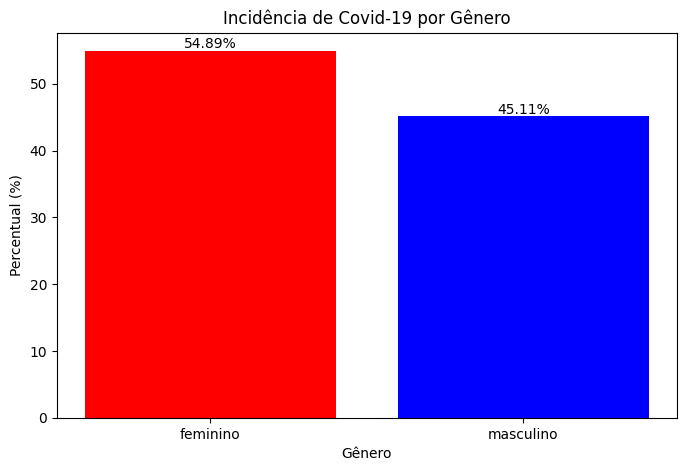

      Gênero    Valor  Percentual
0   feminino  3713669   54.889706
1  masculino  3052024   45.110294


In [31]:
# Dados para o gráfico e tabela
generos = incidencia_genero.index
valores = df_infos_genero['Genero'].value_counts()
percentuais = incidencia_genero

# Criar o gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(generos, percentuais, color=['red', 'blue'])
plt.xlabel('Gênero')
plt.ylabel('Percentual (%)')
plt.title('Incidência de Covid-19 por Gênero')
for i, v in enumerate(percentuais):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', va='center')

plt.show()

# Criar a tabela 2x2
tabela_inciencia_genero = pd.DataFrame({
    'Gênero': generos,
    'Valor': valores.values,
    'Percentual': percentuais.values
})

# Exibir a tabela
print(tabela_inciencia_genero)

# 3. Qual a doença pré-existente mais provável de se encontrar numa pessoa com covid?
Resposta: A doença mais provável de se encontrar é Cardiopatia.

{'Asma': 16411, 'Diabetes': 316171, 'Cardiopatia': 475074, 'Doenca_Hematologica': 4651, 'Doenca_Hepatica': 4800, 'Doenca_Neurologica': 24346, 'Doenca Renal': 32494, 'Imunodepressao': 39746, 'Obesidade': 48904, 'Pneumopatia': 20538, 'Puérpera': 1736, 'Síndrome_De_Down': 1482, 'Outros_Fatores_De_Risco': 154179} 

                     Doença  Frequência  % do total
0               Cardiopatia      475074    7.018229
1                  Diabetes      316171    4.670768
2   Outros_Fatores_De_Risco      154179    2.277674
3                 Obesidade       48904    0.722455
4            Imunodepressao       39746    0.587164
5              Doenca Renal       32494    0.480031
6        Doenca_Neurologica       24346    0.359661
7               Pneumopatia       20538    0.303406
8                      Asma       16411    0.242438
9           Doenca_Hepatica        4800    0.070910
10      Doenca_Hematologica        4651    0.068709
11                 Puérpera        1736    0.025646
12         

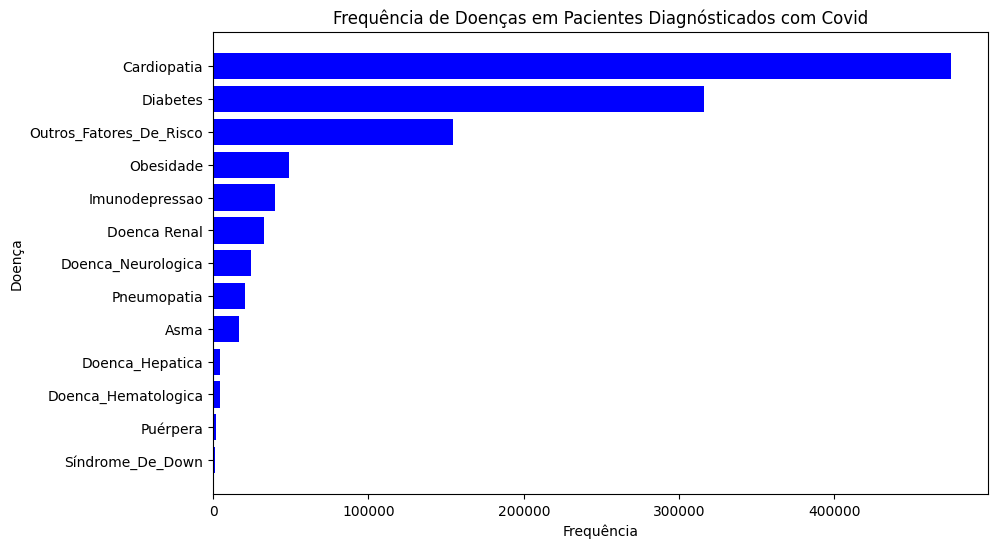

In [32]:
# Dicionário para contar valores de 'sim' por coluna do dataframe de doenças
doencas_count_dict = {}
for column in df_doencas.columns:
    doencas_count_dict[column] = (df_doencas[column] == 'sim').sum()

print(doencas_count_dict,'\n')

#criação de tabela para comparar a frequência de aparição de cada doença e seu % em relação ao total

#tabela com a frequência por doença
frequencia_doenca = pd.DataFrame(list(doencas_count_dict.items()), columns=['Doença', 'Frequência'])

#adição da coluna % do total
frequencia_doenca['% do total'] = (frequencia_doenca['Frequência'] / len(df_doencas)) * 100

# Exibir a tabela em ordem decrescente
frequencia_doenca = frequencia_doenca.sort_values(by='Frequência', ascending=False).reset_index(drop=True)
print(frequencia_doenca)

# Criar um gráfico de barras
#alterar ascending = True para visualização do gráfico de forma decrescente
sim_table = frequencia_doenca.sort_values(by='Frequência', ascending=True).reset_index(drop=True) 
plt.figure(figsize=(10, 6))
plt.barh(sim_table['Doença'],sim_table['Frequência'], color='blue')
plt.xlabel('Frequência')
plt.ylabel('Doença')
plt.title('Frequência de Doenças em Pacientes Diagnósticados com Covid')
plt.show()


# 2. Faça um gráfico da mortalidade por faixas de idade.
- remover idade nulos

In [33]:
df_micro_dados = df_micro_dados.dropna(subset=['Idade'])
infos = ['Genero', 'Municipio', 'Diagnostico_Covid19', 'Idade', 'Obito']
df_infos = df_micro_dados[infos]


Definindo as faixas de idade

In [34]:
# Criar faixas etárias
bins = [0,11, 19, 31, 41, 51, 61, 71, 81, 91, 101]
labels = ['0-10','11-18', '19-30', '31-40', '41-50', '50-60', '60-70', '71-80', '81-90', '91-100']
df_infos['Faixa_Idade'] = pd.cut(df_infos['Idade'], bins=bins, labels=labels, right=False)

Número de Óbitos por faixa de idade

Faixa_Idade
0-10        345
11-18       227
19-30      2658
31-40      8472
41-50     17180
50-60     30647
60-70     42865
71-80     41150
81-90     29721
91-100     8758
Name: Obito, dtype: int64


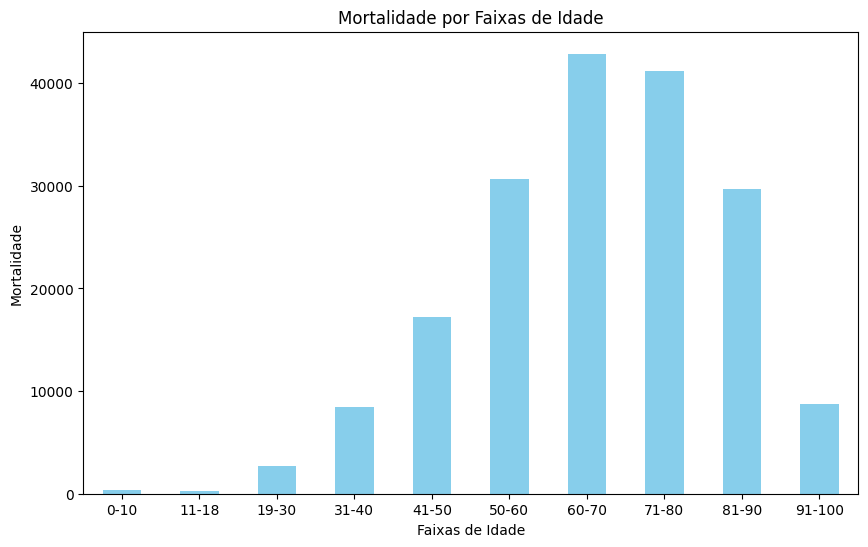

In [35]:
# Calcular óbitos por faixa etária
mortalidade_faixa_idade = df_infos.groupby('Faixa_Idade')['Obito'].sum()
print(mortalidade_faixa_idade)

#plotar gráfico
plt.figure(figsize=(10, 6))
mortalidade_faixa_idade.plot(kind='bar', color='skyblue')
plt.title('Mortalidade por Faixas de Idade')
plt.xlabel('Faixas de Idade')
plt.ylabel('Mortalidade')
plt.xticks(rotation=0)
plt.show()

Taxa de óbitos por faixa de idade
- (número de óbitos na faixa de idade) / (total de pessoas na faixa idade)

  Faixa_Idade  Número de Óbitos  Total de Pessoas  Taxa Mortalidade (%)
0        0-10               345            273333              0.126220
1       11-18               227            348425              0.065150
2       19-30              2658           1355211              0.196132
3       31-40              8472           1415028              0.598716
4       41-50             17180           1212505              1.416901
5       50-60             30647            924012              3.316732
6       60-70             42865            577532              7.422100
7       71-80             41150            290941             14.143761
8       81-90             29721            124744             23.825595
9      91-100              8758             25956             33.741717


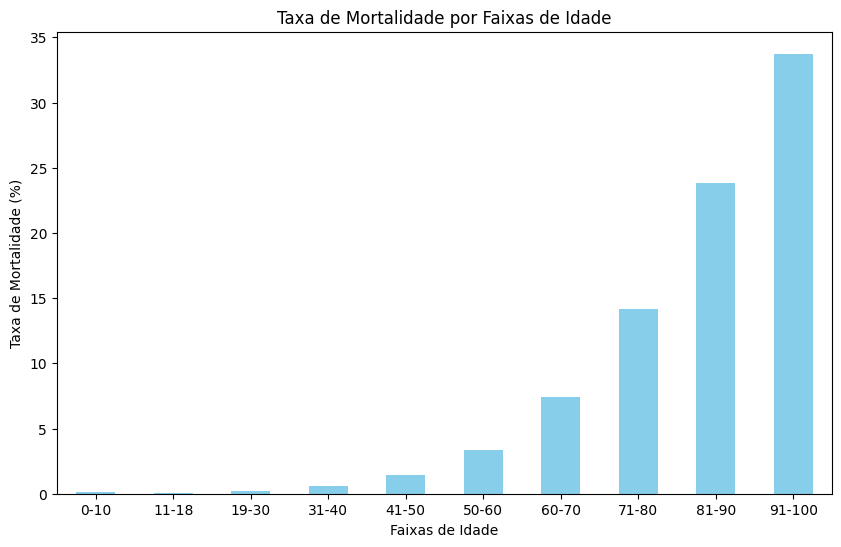

In [36]:
# Calcular o número total de pessoas por faixa etária
total_por_faixa = df_infos.groupby('Faixa_Idade')['Obito'].count()

# Calcular a taxa de mortalidade por faixa etária
taxa_mortalidade_por_faixa = (mortalidade_faixa_idade / total_por_faixa) * 100

# Criar a tabela final
taxa_mortalidade = pd.DataFrame({
    'Número de Óbitos': mortalidade_faixa_idade,
    'Total de Pessoas': total_por_faixa,
    'Taxa Mortalidade (%)': taxa_mortalidade_por_faixa
}).reset_index()

print(taxa_mortalidade)

#gráfico
plt.figure(figsize=(10, 6))
taxa_mortalidade_por_faixa.plot(kind='bar', color='skyblue')
plt.title('Taxa de Mortalidade por Faixas de Idade')
plt.xlabel('Faixas de Idade')
plt.ylabel('Taxa de Mortalidade (%)')
plt.xticks(rotation=0)
plt.show()


# 4. Criação do Modelo

* Baseado nesses dados, faça um modelo que estime a probabilidade da pessoa morrer, uma vez que está       contaminada com covid, e considerando os inputs de idade, gênero e doenças pré-existentes.

Resposta: O melhor modelo criado foi utilizando o algoritmo de Regressão Logística, que retornou uma acurácia de 62.30%

In [37]:
# preparar dataframe
df = df_micro_dados[['Idade', 'Genero'] + list(df_doencas.columns) + ['Obito']]

## Redução de amostras
- O dataset possui muitas amostras o que levaria a um tempo de processamento muito elevado.

 Para isso foram aplicadas as seguintes técnicas para reduzir o número de amostras:
1. Remoção dos valores 'ignorado'.
   1. Permite reduzir o número de amostras, a evitar o ruído de uma categoria não relevante para a análise.
2. Undersampling, redução do número de amostras, baseado nos valores da variável alvo.
   1. Redução do número da classe majoritária (Óbito == 0), ao tamanho da classe minoritária (Óbito ==1).
   2. Resolve o problema de desbalanceamento dos dados.
3. Redução para 10.000 amostras
   1. Menor tempo de processamento permite avaliar diferentes algoritmos, técnicas de otimização de features e de hiperparâmetros.

In [38]:
# Filtrar o DataFrame para remover ignorados
print("Contagem de 'Obito' antes da remoção de valores 'ignorado:")
print(df['Obito'].value_counts())

linhas_ignoradas = df.applymap(lambda x: x == 'ignorado').any(axis=1)
df = df[df['Genero']!='indefinido']
df = df[~linhas_ignoradas]

print("Contagem de 'Obito' antes da subamostragem:")
print(df['Obito'].value_counts())

# Redução do número de amostras (undersampling)
# Dividir os dados em classes majoritária e minoritária
df_majority = df[df.Obito == 0]  
df_minority = df[df.Obito == 1]  

# Subamostrar a classe majoritária
df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=42)

print("Contagem de 'Obito' após a primeira subamostragem:")
print(df['Obito'].value_counts())

#reduzindo para 10000 amostras
df_majority_downsampled = df_majority_downsampled.sample(n=5000, random_state=42)
df_minority_downsampled = df_minority.sample(n=5000, random_state=42)

# Combinar a classe minoritária com a classe majoritária subamostrada
df_balanced = pd.concat([df_minority_downsampled, df_majority_downsampled])

# Verificar as contagens de 'Obito' após a subamostragem
print("\nContagem de 'Obito' após a segunda subamostragem:")
print(df_balanced['Obito'].value_counts())
df = df_balanced
df

Contagem de 'Obito' antes da remoção de valores 'ignorado:
Obito
0    6365664
1     182023
Name: count, dtype: int64
Contagem de 'Obito' antes da subamostragem:
Obito
0    129519
1     72966
Name: count, dtype: int64
Contagem de 'Obito' após a primeira subamostragem:
Obito
0    129519
1     72966
Name: count, dtype: int64

Contagem de 'Obito' após a segunda subamostragem:
Obito
1    5000
0    5000
Name: count, dtype: int64


,Idade,Genero,Asma,Diabetes,Cardiopatia,Doenca_Hematologica,Doenca_Hepatica,Doenca_Neurologica,Doenca Renal,Imunodepressao,Obesidade,Pneumopatia,Puérpera,Síndrome_De_Down,Outros_Fatores_De_Risco,Obito
4024824,59.0,masculino,não,sim,não,não,não,não,não,não,sim,não,não,não,sim,1
4919335,48.0,feminino,não,sim,não,não,não,não,não,não,não,não,não,não,não,1
2574819,75.0,masculino,não,não,sim,não,não,não,não,não,não,não,não,não,não,1
4000015,44.0,masculino,não,sim,não,não,não,não,não,não,não,não,não,não,não,1
5164194,75.0,masculino,não,não,não,não,não,não,sim,não,não,não,não,não,não,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5950005,68.0,feminino,não,sim,sim,não,não,não,não,não,não,não,não,não,sim,0
5823051,53.0,feminino,não,não,não,não,não,não,não,não,não,não,não,não,sim,0
1871805,82.0,masculino,não,não,sim,não,não,não,não,não,não,não,não,não,não,0
123491,47.0,feminino,não,sim,não,não,não,não,não,sim,não,não,não,não,não,0


Split do dataset em treino e teste

In [39]:
#treino : X (80%)
#teste: y (20%)
X = df.drop(columns='Obito')
y = df.pop('Obito')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
print(f' Treino: x ={X_train.shape} ; y = {y_train.shape}')
print(f' Teste: x ={X_test.shape} ; y = {y_test.shape}')

 Treino: x =(8000, 15) ; y = (8000,)
 Teste: x =(2000, 15) ; y = (2000,)


Transformar variáveis categóricas em numéricas para aplicação no modelo

In [41]:
# Colunas que não serão tratadas como as colunas de doenças
exclude_columns = ['Idade','Genero']

# criando uma cópia do split original de treino
X_train_transformed = X_train.copy()
X_test_transformed = X_test.copy()

# Transformando as variáveis categóricas em binárias

# Doenças
for column in X_train.columns:
    if column not in exclude_columns:
        X_train_transformed[column] = X_train[column].map({'sim': 1, 'não': 0})
        X_test_transformed[column] = X_test[column].map({'sim': 1, 'não': 0})

# Gênero 
X_train_transformed['Genero'] = X_train['Genero'].apply(lambda x: 1 if x == 'masculino' else 0)
X_test_transformed['Genero'] = X_test['Genero'].apply(lambda x: 1 if x == 'masculino' else 0)

# Normalizando a variável numérica idade usando MinMax (0-1)
scaler = MinMaxScaler()
X_train_transformed['Idade'] = scaler.fit_transform(X_train[['Idade']])
X_test_transformed['Idade'] = scaler.transform(X_test[['Idade']])

In [42]:
# retomando a nomenclatura original 
X_train = X_train_transformed
X_test = X_test_transformed

## Aplicando Diferentes Algoritmos de Classificação

In [43]:
# Treinar e avaliar o modelo de Regressão Logística
modelo_lr = LogisticRegression(max_iter=1000)
modelo_lr.fit(X_train, y_train)

y_pred_lr = modelo_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, modelo_lr.predict_proba(X_test)[:, 1])

resultados = {}
resultados['Regressão Logística'] = {'Accuracy': accuracy_lr, 'ROC AUC': roc_auc_lr}

print(f"SVM - Accuracy: {accuracy_lr:.4f}")
print(f"SVM - ROC AUC: {roc_auc_lr:.4f}")

SVM - Accuracy: 0.6230
SVM - ROC AUC: 0.6654


In [44]:
# Treinar e avaliar o modelo de SVM
modelo_svm = SVC(probability=True)
modelo_svm.fit(X_train, y_train)

y_pred_svm = modelo_svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, modelo_svm.predict_proba(X_test)[:, 1])



resultados['SVM'] = {'Accuracy': accuracy_svm, 'ROC AUC': roc_auc_svm}

print(f"SVM - Accuracy: {accuracy_svm:.4f}")
print(f"SVM - ROC AUC: {roc_auc_svm:.4f}")

SVM - Accuracy: 0.6115
SVM - ROC AUC: 0.6550


In [45]:
# Treinar e avaliar o modelo de Random Forest
modelo_rf = RandomForestClassifier(n_jobs=-1)
modelo_rf.fit(X_train, y_train)

y_pred_rf = modelo_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, modelo_rf.predict_proba(X_test)[:, 1])

resultados['Random Forest'] = {'Accuracy': accuracy_rf, 'ROC AUC': roc_auc_rf}

print(f"Random Forest - Accuracy: {accuracy_rf:.4f}")
print(f"Random Forest - ROC AUC: {roc_auc_rf:.4f}")

Random Forest - Accuracy: 0.5755
Random Forest - ROC AUC: 0.6048


In [46]:
# Treinar e avaliar o modelo de K-Nearest Neighbors
modelo_knn = KNeighborsClassifier()
modelo_knn.fit(X_train, y_train)

y_pred_knn = modelo_knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
roc_auc_knn = roc_auc_score(y_test, modelo_knn.predict_proba(X_test)[:, 1])

resultados['K-Nearest Neighbors'] = {'Accuracy': accuracy_knn, 'ROC AUC': roc_auc_knn}

print(f"K-Nearest Neighbors - Accuracy: {accuracy_knn:.4f}")
print(f"K-Nearest Neighbors - ROC AUC: {roc_auc_knn:.4f}")

K-Nearest Neighbors - Accuracy: 0.5910
K-Nearest Neighbors - ROC AUC: 0.6083


Comparar resultados, avaliar melhor modelo

Tabela de Comparação dos Modelos:
                     Accuracy   ROC AUC
Regressão Logística    0.6230  0.665389
SVM                    0.6115  0.655029
Random Forest          0.5755  0.604807
K-Nearest Neighbors    0.5910  0.608300


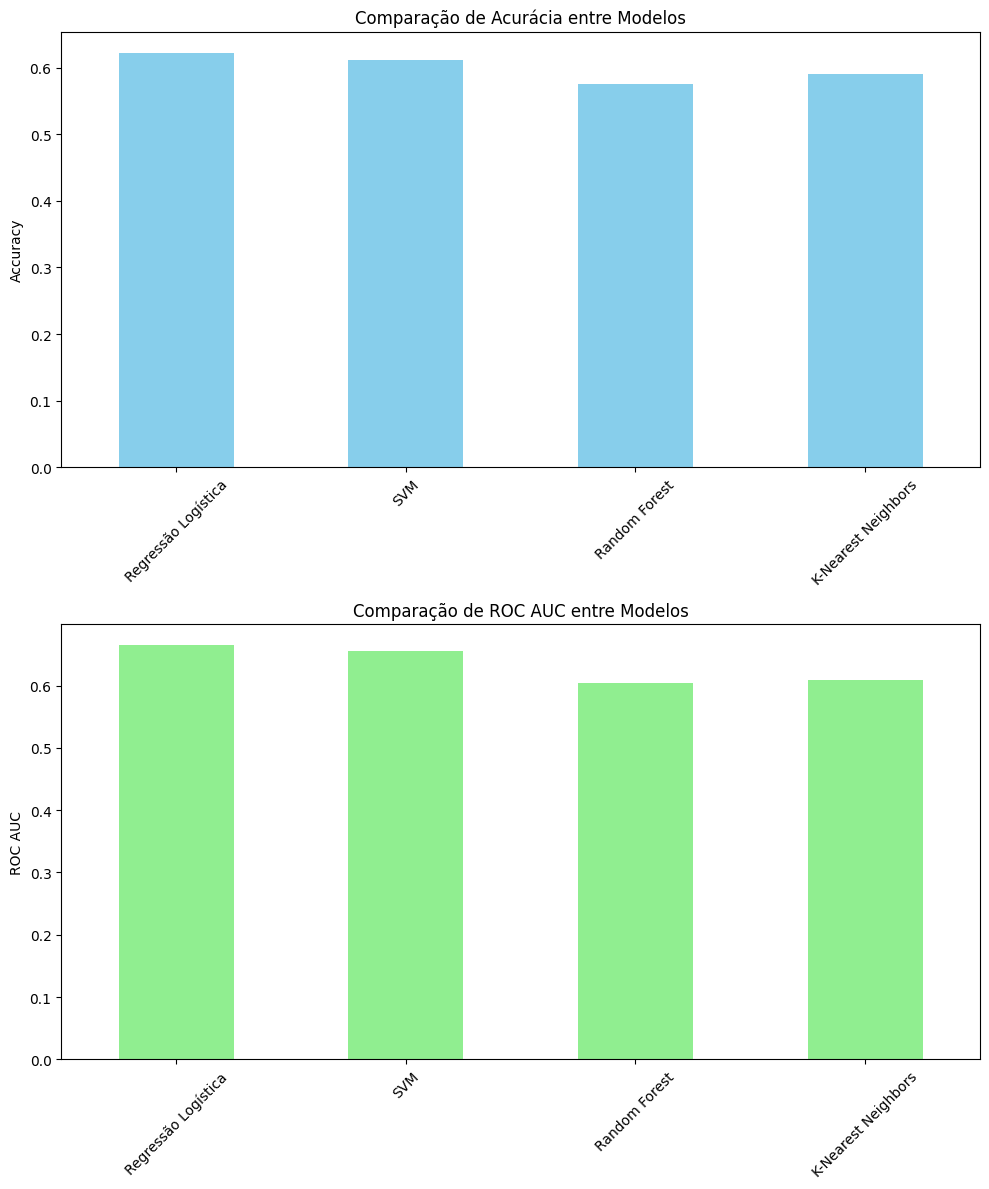

In [47]:
resultados_df = pd.DataFrame(resultados).T

# Exibir a tabela
print("Tabela de Comparação dos Modelos:")
print(resultados_df)

# Plotar os resultados de Accuracy e ROC AUC
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Gráfico de Accuracy
resultados_df['Accuracy'].plot(kind='bar', ax=ax[0], color='skyblue')
ax[0].set_title('Comparação de Acurácia entre Modelos')
ax[0].set_ylabel('Accuracy')
ax[0].set_xticklabels(resultados_df.index, rotation=45)

# Gráfico de ROC AUC
resultados_df['ROC AUC'].plot(kind='bar', ax=ax[1], color='lightgreen')
ax[1].set_title('Comparação de ROC AUC entre Modelos')
ax[1].set_ylabel('ROC AUC')
ax[1].set_xticklabels(resultados_df.index, rotation=45)

plt.tight_layout()
plt.show()

### Conslusões
- Os modelos de Regressão Logística SVM apresentaram os melhores resultados, sem otimização de hiperparâmetros, para as métricas de Área sob a curva ROC e acurácia.

## Tentativa de melhorar a resposta do modelo
- Otimizar Hiper Parâmetros
  - Utilizar grid search para encontrar o melhor hiperparâmetro
- Avaliar o melhor número de features usando RFE

Otimizar Hiperparâmetros e features Regressão Logística

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
LogisticRegression(C=0.1, max_iter=10000, penalty='l1', solver='saga')

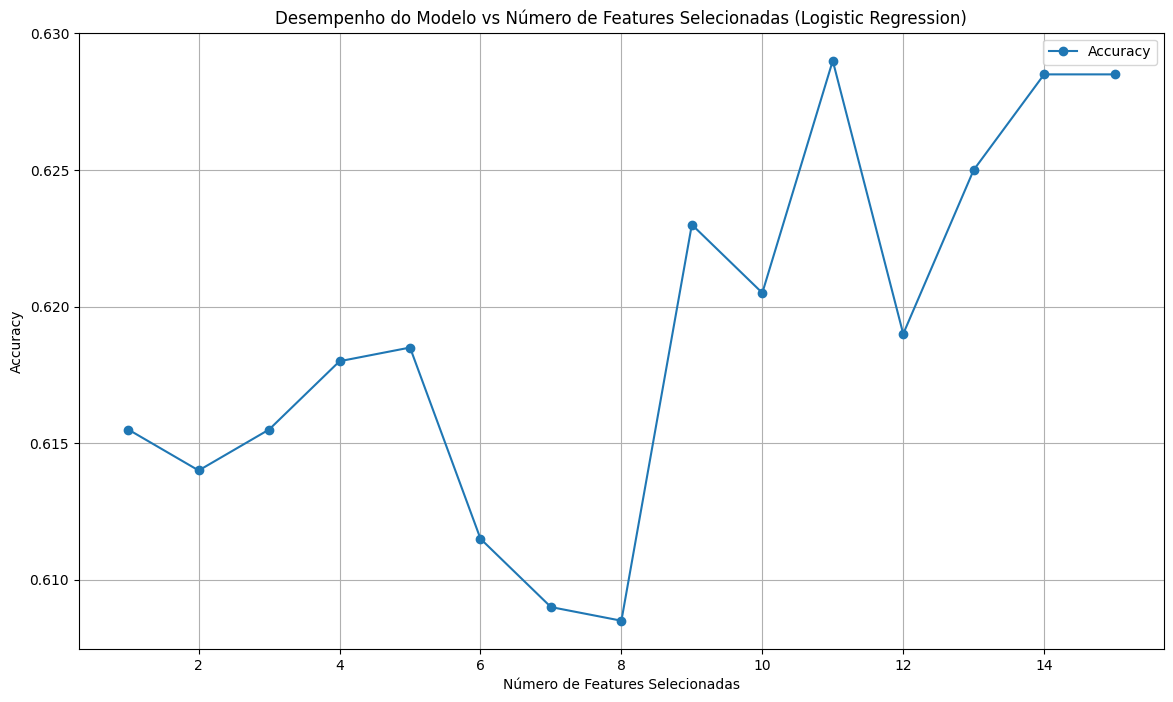

In [48]:
# Inicializar o estimador
estimator = LogisticRegression(max_iter=10000)

# Listas para armazenar as métricas
num_features = list(range(1, X_train.shape[1] + 1))
accuracy_scores = []

# Hiperparâmetros para otimização
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [10000]  # Garantindo que o modelo tenha iterações suficientes para convergir
}

# Loop através de diferentes números de features
for n in num_features:
    rfe = RFE(estimator=estimator, n_features_to_select=n)
    rfe = rfe.fit(X_train, y_train)
    
    # Transformar os conjuntos de treino e teste para selecionar as principais features
    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)
    
    # Inicializar e realizar Grid Search no modelo de regressão logística
    lr_model = LogisticRegression(max_iter=10000)
    grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
    grid_search.fit(X_train_rfe, y_train)
    
    # Usar o melhor modelo encontrado pelo Grid Search
    best_lr_model = grid_search.best_estimator_
    
    # Fazer previsões no conjunto de teste
    y_pred_lr_test = best_lr_model.predict(X_test_rfe)
    
    # Calcular a acurácia
    accuracy = accuracy_score(y_test, y_pred_lr_test)
    
    # Armazenar a métrica
    accuracy_scores.append(accuracy)

print(grid_search.best_estimator_)

# Plotar a acurácia em relação ao número de features
plt.figure(figsize=(14, 8))
plt.plot(num_features, accuracy_scores, label='Accuracy', marker='o')
plt.xlabel('Número de Features Selecionadas')
plt.ylabel('Accuracy')
plt.title('Desempenho do Modelo vs Número de Features Selecionadas (Logistic Regression)')
plt.legend()
plt.grid(True)
plt.show()


Otimizar features SVM
- Otimização de hiperparâmetros com grid search levou um tempo de processamento muito longo.

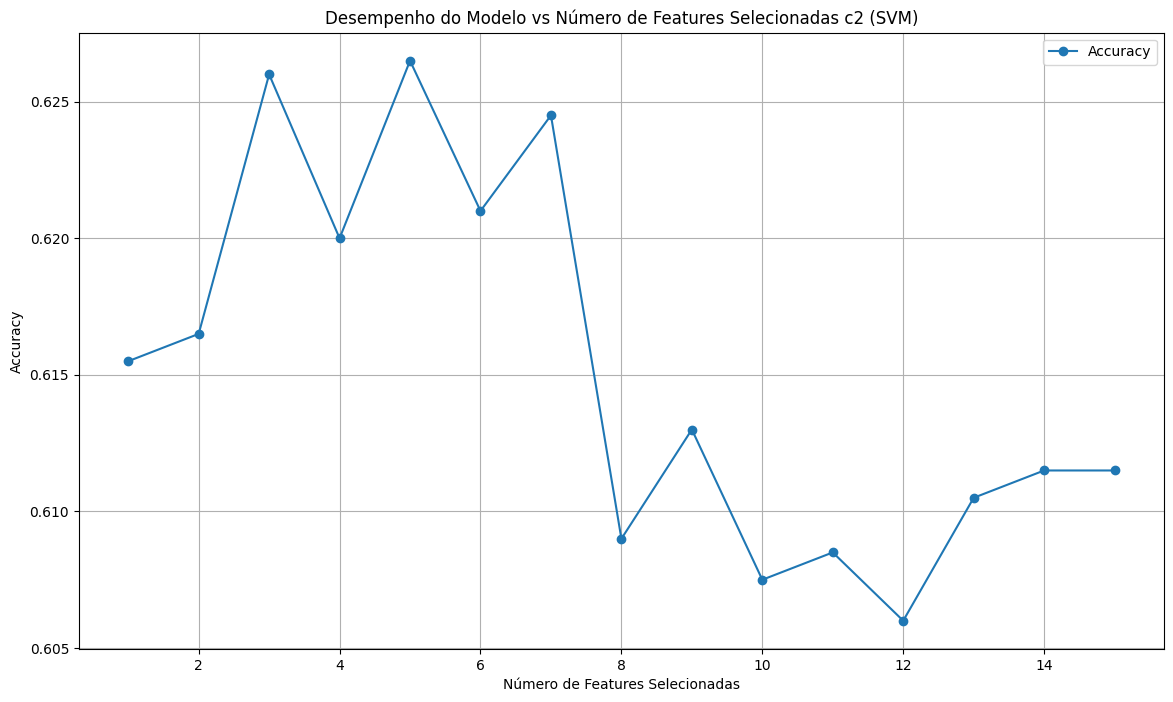

In [49]:
estimator = DecisionTreeClassifier()

# Listas para armazenar as métricas
num_features = list(range(1, X_train.shape[1] + 1))
accuracy_scores = []

# Loop através de diferentes números de features
for n in num_features:
    rfe = RFE(estimator=estimator, n_features_to_select=n)
    rfe = rfe.fit(X_train, y_train)
    
    # Transformar os conjuntos de treino e teste para selecionar as principais features
    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)
    
    # Inicializar e treinar o modelo SVM
    svm_model = SVC()
    svm_model.fit(X_train_rfe, y_train)    
    # Fazer previsões no conjunto de teste
    y_pred_svm_test_c2 = svm_model.predict(X_test_rfe)
    
    # Calcular a acurácia
    accuracy = accuracy_score(y_test, y_pred_svm_test_c2)
    
    # Armazenar a métrica
    accuracy_scores.append(accuracy)

# Plotar a acurácia em relação ao número de features
plt.figure(figsize=(14, 8))
plt.plot(num_features, accuracy_scores, label='Accuracy', marker='o')
plt.xlabel('Número de Features Selecionadas')
plt.ylabel('Accuracy')
plt.title('Desempenho do Modelo vs Número de Features Selecionadas c2 (SVM)')
plt.legend()
plt.grid(True)
plt.show()

Otimizar Hiperparâmetros e features random forest
- (aproximadamente 4mins de execução)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
RandomForestClassifier(criterion='entropy', max_depth=10, max_features

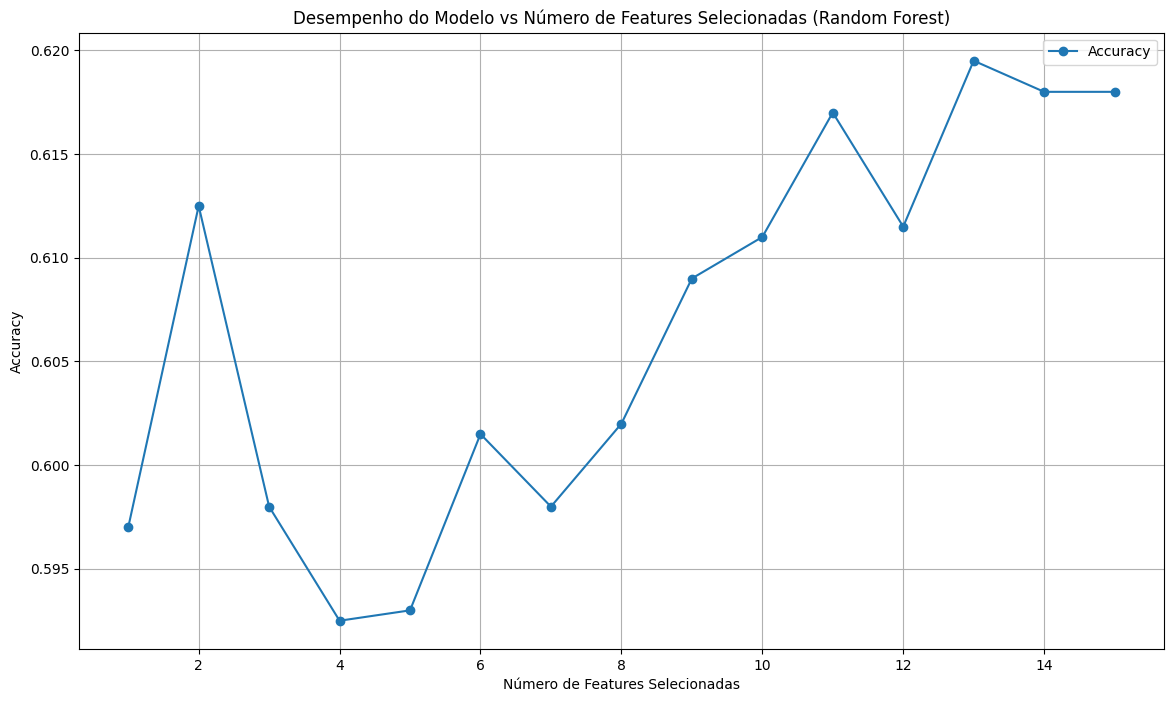

In [50]:
# Inicializar o estimador
estimator = RandomForestClassifier()

# Listas para armazenar as métricas
num_features = list(range(1, X_train.shape[1] + 1))
accuracy_scores = []

# Hiperparâmetros para otimização
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'criterion': ['gini', 'entropy']
}

# Loop através de diferentes números de features
for n in num_features:
    rfe = RFE(estimator=estimator, n_features_to_select=n)
    rfe = rfe.fit(X_train, y_train)
    
    # Transformar os conjuntos de treino e teste para selecionar as principais features
    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)
    
    # Inicializar e realizar Grid Search no modelo Random Forest
    rf_model = RandomForestClassifier()
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
    grid_search.fit(X_train_rfe, y_train)
    
    # Usar o melhor modelo encontrado pelo Grid Search
    best_rf_model = grid_search.best_estimator_
    
    # Fazer previsões no conjunto de teste
    y_pred_rf_test = best_rf_model.predict(X_test_rfe)
    
    # Calcular a acurácia
    accuracy = accuracy_score(y_test, y_pred_rf_test)
    
    # Armazenar a métrica
    accuracy_scores.append(accuracy)

print(grid_search.best_estimator_)

# Plotar a acurácia em relação ao número de features
plt.figure(figsize=(14, 8))
plt.plot(num_features, accuracy_scores, label='Accuracy', marker='o')
plt.xlabel('Número de Features Selecionadas')
plt.ylabel('Accuracy')
plt.title('Desempenho do Modelo vs Número de Features Selecionadas (Random Forest)')
plt.legend()
plt.grid(True)
plt.show()


Avaliação das features mais importantes, baseado no RF

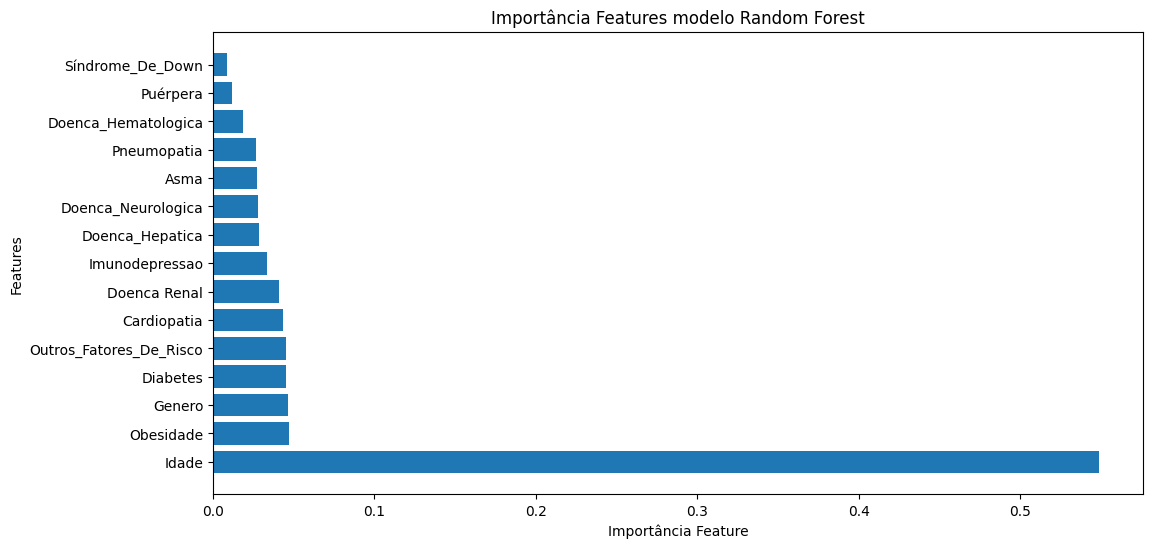

In [51]:
# Importância de cada feature
rfe.fit(X_train, y_train)  # Ajustar o RFE novamente para obter as features selecionadas
selected_features = np.array(X_train.columns)[rfe.support_]

# Treinar o modelo final com todas as features selecionadas
best_rf_model.fit(rfe.transform(X_train), y_train)

# Importância das features no modelo final
feature_importances = best_rf_model.feature_importances_

# Ordenar importâncias e features correspondentes
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = selected_features[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

plt.figure(figsize=(12, 6))
plt.barh(sorted_features, sorted_importances)
plt.xlabel('Importância Feature')
plt.ylabel('Features')
plt.title('Importância Features modelo Random Forest')
plt.show()

#### Conclusão
Como a otimização de hiperparâmetros e features não se mostrou eficiente para aumentar a eficácia do modelo, não será criado o subset de validação e essa etapa não será aplicada no modelo final. 

# Comentários Sugestões Futuras
O modelo obteve uma baixa performance para classificar o óbito em pessoas diagnosticadas com covid a partir de sua idade, gênero e doenças preexistentes, alcançando uma acurácia de 62.30%. 


Comentários:
- A variável de idade se mostrou a mais relevante para o óbito da pessoa diagnosticada do covid, em comparação com as demais.
- A otimização de hiperparâmetros teve pouco impacto para aumentar a acurácia do modelo, por isso não foi mais profundamente explorada com a criação de um dataset de validação.

Sugestões Futuras:
- Explorar outras formas de redução de amostragem do modelo, a forma utilizada pode ter sido o principal responsável pelo baixo desempenho do modelo.
- Uso de outros algoritmos mais robustos para a análise como redes convolucionais CNN.